# Regularization


In this deep learning course, we've seen that neural networks are very effective at solving various problems. However, some major issues limit their potential. Today, we'll discuss *overfitting*.

*Overfitting* occurs when the model adapts too precisely to the training data, even capturing anomalies and noise. As a result, its performance on test data is poor.

![Overfitting](./images/overfitting.png)

This problem is common when training neural networks. To monitor it, we use a validation dataset that we regularly evaluate to ensure the *loss* is decreasing. In case of *overfitting*, the training and validation *loss* curves look like this:

![Overfitting Curve](./images/overfittingcurve.png)

The training *loss* continues to decrease, while the validation *loss* increases. This shows that the model is learning the specifics of the training data, which is the opposite of what we want.

Thinking about it, it makes sense: the model tries to minimize the *loss* on the training data.

This is a crucial point to consider when training a neural network. To combat this problem, several techniques exist. We'll present two here, trying to understand why they work.

These two methods are **L2 regularization** and ***dropout***. This notebook is inspired by the [fastai course](https://github.com/fastai/fastbook/tree/master).


## L2 Regularization


L2 regularization is a simple technique. It involves adding the sum of the squared weights to the *loss* function (with a factor $wd$ called *weight_decay*). This term in the *loss* function encourages the weights to be as small as possible.


### Why does this reduce overfitting?


Intuitively, larger weights can create steeper slopes in the *loss* function.

To confirm this intuition, let's look at what happens with the parabola function:
$y=a \times x^2$


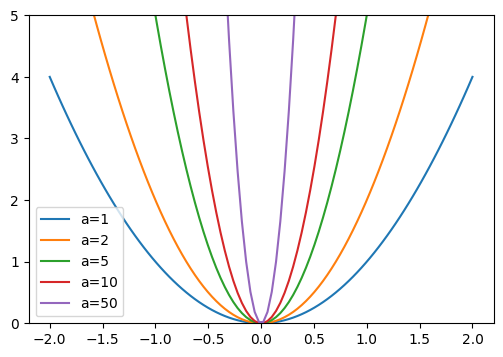

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(6,4))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

The larger $a$ becomes, the steeper the parabola becomes. If we compare $a$ to our weights, we can imagine that large weights lead to a function represented by a network with abrupt changes, which can correspond to *overfitting*.

This justification may seem a bit "magical," but in practice, L2 regularization really has a positive impact on preventing *overfitting*.

Limiting the value of the weights also reduces the network's learning capacity. However, this limitation allows for better generalization and avoids *overfitting*.


### Method Implementation


To implement L2 regularization, you can do it manually by adding the term to our *loss*:
$L(w) = L_0(w) + wd \sum_{i=1}^{n} w_i^2$ where $L(w)$ is the regularized loss, $L_0(w)$ is the classic loss function, $wd$ (*weight_decay*) is the regularization coefficient, and $w_i$ is a weight of the model.
or ```loss_regu = loss + wd * (parameters**2).sum()``` in Python.

More simply, you can use L2 regularization in PyTorch by adding the *weight_decay* parameter during the optimizer initialization (default is 0).
For example:


In [ ]:
import torch
params=torch.tensor([1.0], requires_grad=True)
# Pour SGD
torch.nn.optim.SGD(params, lr=0.1, weight_decay=0.1)
# Pour Adam
torch.nn.optim.Adam(params, lr=0.1, weight_decay=0.1)

If your model has *overfitting* issues, this is a method to try!


## Dropout


*Dropout* is a regularization method introduced in the paper [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580). The idea is simple: at each training step, a random subset of the network's activations is set to zero. Thus, each neuron becomes necessary to produce a consistent *output* from the *input*.

![Dropout](./images/dropout.png)


### Intuition


To understand *dropout*, we can use a metaphor from the author of the paper (Geoffrey Hinton):

*"I went to my bank. The tellers were constantly changing, and I asked one of them why. He said he didn't know, but they were often moved around. I thought this must be because it would require cooperation among the employees to set up a bank fraud, and thus it greatly limits the possibilities of doing so. This made me realize that randomly removing a different subset of neurons for each example would prevent conspiracies and thus reduce overfitting."*

This prevents neurons from "cheating," i.e., finding a fraudulent shortcut for a prediction (one might assume that each neuron relies on a detail of the input solely to make its prediction).

This method encourages neurons to cooperate and increases noise in the activations, leading to a more robust model. We can also see *dropout* as a blend of many small models that cooperate during the testing phase.


### Implementation


You can implement *dropout* in Python like this:


In [4]:
import torch.nn as nn
class Dropout(nn.Module):
  def __init__(self, p): 
    self.p = p
  def forward(self, x):
    # Le droupout n'est appliqué que pendant l'entrainement
    if not self.training: 
      return x
    # On crée un masque de dropout à partir d'une distribution de Bernoulli
    mask = torch.zeros_like(x)
    mask.bernoulli_(1 - self.p) # chaque élément a une probabilité de 1-p d'être mis à 0 sinon il est mis à 1
    # On applique le masque et on divise par 1-p pour garder une moyenne cohérente
    return x * mask/(1-self.p)

The layer is also implemented in PyTorch, and you can use it with [nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), which takes the parameter $p$ as the probability that an activation is set to zero.

**Note**: When using PyTorch's *dropout*, be sure to set the model to train mode during training and eval mode during validation/testing (as with *batchnorm*). You can do this with ```model.train()``` and ```model.eval()```.
